# Imports 

In [43]:
# Standard library imports
import os
import random
import time
import warnings
from collections import defaultdict

# Third-party library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Suppress warnings (optional)
warnings.filterwarnings("ignore", category=UserWarning)

# Data

### preprocces method


In [44]:
def process_data(file_path, per_cluster=500):
    # Read the data
    data = pd.read_csv(file_path, header=None)
    
    if per_cluster:
        # Filter the data to keep only the specified number of entries per cluster
        filtered_data = data.groupby(0).apply(lambda x: x.head(per_cluster)).reset_index(drop=True)
    else:
        # If per_cluster is not specified, use all the data
        filtered_data = data
    
    # Extract feature columns and true labels
    X = filtered_data.iloc[:, 3:].values  # Feature columns
    true_labels = filtered_data.iloc[:, 0].values  # True labels (BLOCK ID)
    
    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, true_labels

In [45]:
#random data
def random_data_load(dvide_amount = 10):
    full_data = pd.read_csv('bio_train.csv')

    # We will consider all rows this time, without filtering by groups
    # Setting the first column as labels and the rest as features
    full_true_labels = full_data.iloc[:, 0].values  # True labels
    full_X = full_data.iloc[:, 1:].values  # Feature columns

    # Normalize the full features
    full_scaler = StandardScaler()
    full_X_scaled = full_scaler.fit_transform(full_X)



    X = full_X_scaled
    X_scaled = full_X_scaled
    true_labels = full_true_labels

    # shuffle and select 10% of the data, however keep x and y together
    np.random.seed(0)
    shuffle = np.random.permutation(len(X))
    X = X[shuffle]
    true_labels = true_labels[shuffle]

    # use 5% of the data
    X = X[:len(X) // dvide_amount]
    true_labels = true_labels[:len(true_labels) // dvide_amount]

    X_scaled = X


    return X_scaled, true_labels

load the actual data (here 10%  for example)

In [46]:
X_scaled, true_labels = random_data_load(10)
X, true_labels = random_data_load(10)

# Clustring routine (helper function)

In [47]:
def perform_clustering(X, k, max_iters, num_loops, clustering_function, **kwargs):
    all_labels = []
    all_centroids = []
    all_nmi_scores = []
    all_runtimes = []
    all_distance_calculations = []
    all_inertia_histories = []
    all_num_iterations = []

    for i in range(num_loops):
        # Ensure max_iters is passed correctly as a keyword argument
        centroids, labels, num_iterations, inertia_history, distance_calculations, runtime = clustering_function(
            X, k, max_iters, **kwargs
        )
        nmi_score = normalized_mutual_info_score(true_labels, labels, average_method='arithmetic')
        
        # Append results to lists
        all_num_iterations.append(num_iterations)
        all_labels.append(labels)
        all_centroids.append(centroids)
        all_nmi_scores.append(nmi_score)
        all_runtimes.append(runtime)
        all_distance_calculations.append(distance_calculations)
        all_inertia_histories.append(inertia_history)

    return {
        'centroids': all_centroids,
        'labels': all_labels,
        'num_iterations': all_num_iterations,
        'inertia_histories': all_inertia_histories,
        'distance_calculations': all_distance_calculations,
        'runtimes': all_runtimes,
        'nmi_scores': all_nmi_scores
    }


# Visualization

In [48]:
def visualize_clustering_results(results):
    # Extract the results
    all_inertia_histories = results['inertia_histories']
    all_nmi_scores = results['nmi_scores']
    all_runtimes = results['runtimes']
    all_distance_calculations = results['distance_calculations']
    
    # Define a list of colors for the bars
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'grey']
    
    def plot_line(data, title, xlabel, ylabel, yscale='linear'):
        plt.figure(figsize=(10, 8))
        if isinstance(data[0], list):
            for i, history in enumerate(data):
                plt.plot(history, label=f'Run {i+1}')
            plt.legend()
        else:
            plt.plot(data, label='Run 1')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.yscale(yscale)
        plt.grid(True)
        plt.show()

    def plot_bar(data, avg, title, xlabel, ylabel):
        plt.figure(figsize=(10, 6))
        if isinstance(data, list):
            bar_data = data + [avg]
            xticks_labels = [f'Run {i}' for i in range(1, len(data)+1)] + ['Average']
        else:
            bar_data = [data, avg]
            xticks_labels = ['Run 1', 'Average']
        
        plt.bar(range(1, len(bar_data) + 1), bar_data, color=colors[:len(bar_data)], alpha=0.7)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.xticks(range(1, len(bar_data) + 1), labels=xticks_labels)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.show()
    
    # Plot the inertia histories
    plot_line(all_inertia_histories, 'K-means Convergence', 'Iteration', 'Inertia', yscale='log')
    
    # Plot the runtimes
    average_runtime = np.mean(all_runtimes) if isinstance(all_runtimes, list) else all_runtimes
    plot_bar(all_runtimes, average_runtime, 'Runtimes for Each Run and Average Runtime', 'Run Number', 'Runtime (seconds)')
    
    # Plot the distance calculations
    average_distance_calculations = np.mean(all_distance_calculations) if isinstance(all_distance_calculations, list) else all_distance_calculations
    plot_bar(all_distance_calculations, average_distance_calculations, 'Distance Calculations for Each Run and Average', 'Run Number', 'Number of Distance Calculations')
    
    # Calculate and print average NMI score
    average_nmi = np.mean(all_nmi_scores) if isinstance(all_nmi_scores, list) else all_nmi_scores
    print(f"Average NMI Score: {average_nmi:.4f}")
    

#  Lloyd’s algorithm for k-Means Clustering 

In [49]:
# Custom K-means and related functions
def initialize_centroids(X, k):
    """Randomly initialize centroids from the data points X."""
    indices = np.random.permutation(X.shape[0])[:k]
    return X[indices]

def assign_clusters(X, centroids):
    """Assign data points to the nearest centroid using batch processing."""
    n_samples = X.shape[0]
    batch_size = 100  # Adjust batch size based on available memory
    labels = np.empty(n_samples, dtype=int)
    
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        distances = np.sqrt(((X[start_idx:end_idx] - centroids[:, np.newaxis])**2).sum(axis=2))
        labels[start_idx:end_idx] = np.argmin(distances, axis=0)
    
    return labels


def update_centroids(X, labels, k):
    """Update centroids as the mean of assigned data points."""
    new_centroids = np.empty((k, X.shape[1]))
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            new_centroids[i] = cluster_points.mean(axis=0)
        else:
            # If cluster has no assigned points, randomly reinitialize the centroid
            new_centroids[i] = X[np.random.choice(X.shape[0])]
    return new_centroids


def kmeans(X, k, max_iters=5000):
    centroids = initialize_centroids(X, k)
    inertia_history = []
    total_distance_calculations = 0
    start_time = time.time()  # Start timing

    for i in tqdm(range(max_iters), desc="K-means Iteration"):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        inertia = np.sum((X - centroids[labels])**2)
        inertia_history.append(inertia)
        total_distance_calculations += X.shape[0] * k  # Each assign_clusters call
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    runtime = time.time() - start_time  # End timing
    return centroids, labels, i + 1, inertia_history, total_distance_calculations, runtime

In [50]:
results_k_means = perform_clustering(X_scaled, 153, 50, 5, kmeans)

K-means Iteration:  62%|██████▏   | 31/50 [00:31<00:19,  1.02s/it]


KeyboardInterrupt: 

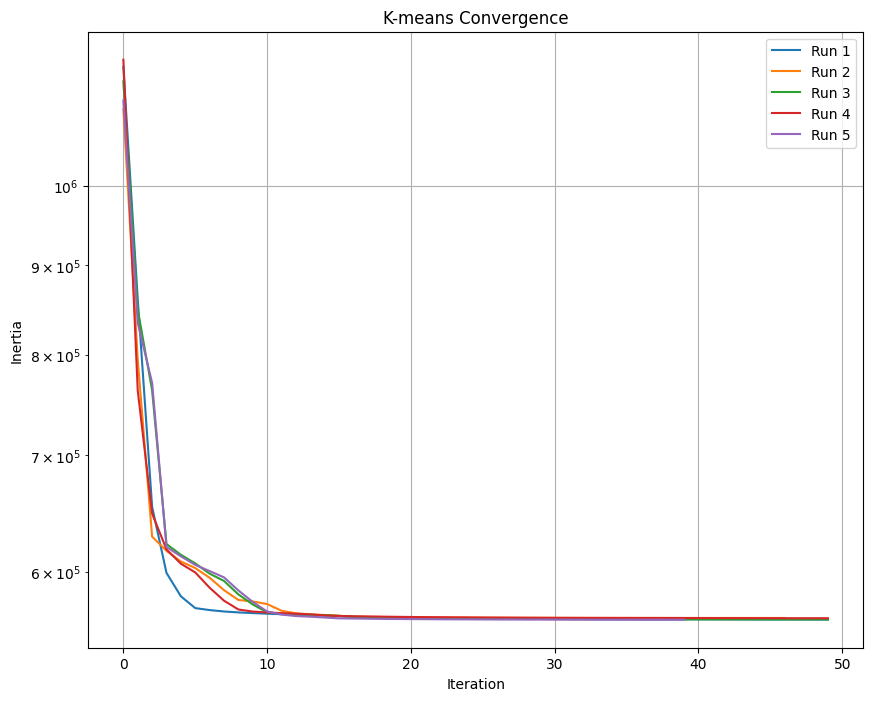

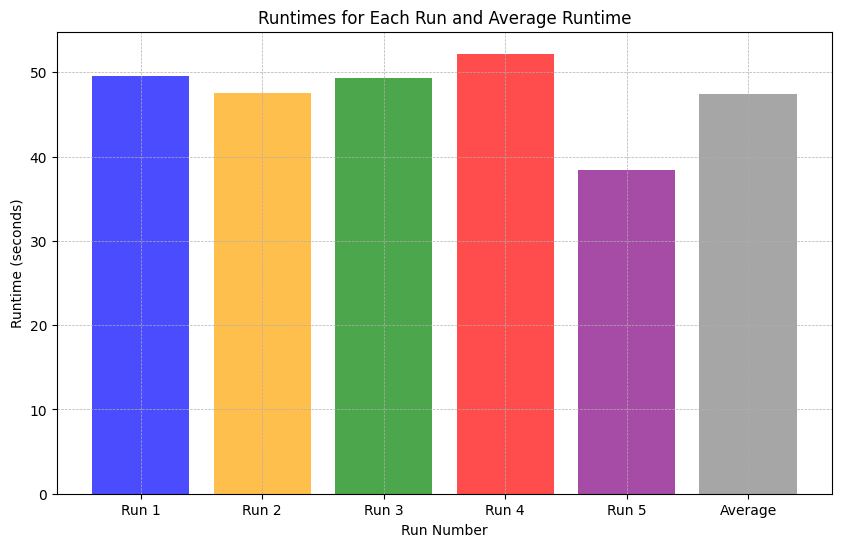

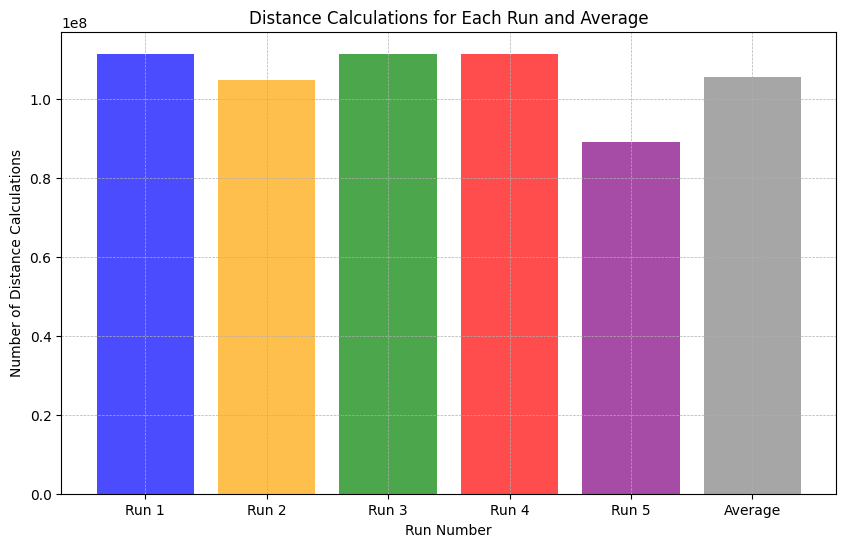

Average NMI Score: 0.2749


In [ ]:
visualize_clustering_results(results_k_means)

# k-Means with Locality Sensitive Hashing (LSH)

We have implemented the lsh_has_function as given in the assignement.   
The hash function $h_{a,b}(p): \mathbb{R}^d \rightarrow \mathbb{N}$ maps a point $p \in \mathbb{R}^d$ to a natural number, defined as:   
$ h_{a,b}(p) = \left\lfloor \frac{{\mathbf{a \cdot p} + b}}{{w}} \right\rfloor $

Where:
- $a$ is a random vector in $\mathbb{R}^d$,
- $b$ is a scalar parameter in the range $[0, w]$,
- $w$ is a scalar parameter determining the width of the hash bins,
- $\mathbf{a \cdot p}$ denotes the dot product between vectors $a$ and $p$.

This is done in lsh_hash_function, so first we initialize the lsh with initialize_lsh, where we create a number of a and b vectors according to the number of hash funcs we want. Then we compute the hash signitatur for every point with compute_lsh_hashes

## helper functions

In [51]:


# Define a function to compute the Euclidean distance
def euclidean_distance(point, centroids):
    return np.sqrt(np.sum((centroids - point) ** 2, axis=1))

def lsh_hash_function(X, a, b, w):
    projection = X.dot(a.T)  # Transpose `a` to make dot product correct
    shifted_projection = projection + b
    normalized_value = shifted_projection / w
    bin_index = np.floor(normalized_value).astype(int)
    return bin_index

def initialize_lsh(X, n, m, w):
    num_data_points, d = X.shape
    a = np.random.randn(n * m, d)
    b = np.random.uniform(0, w, n * m)
    return a, b, w

def compute_lsh_hashes(X, a, b, w):
    return lsh_hash_function(X, a, b, w)

def assign_to_buckets(hashes):
    bucket_dict = defaultdict(list)
    for index, hash_values in enumerate(hashes):
        hash_tuple = tuple(hash_values)
        bucket_dict[hash_tuple].append(index)
    return bucket_dict

def create_centroid_slice_map(centroids, a, b, w, n, m):
    centroid_slice_map = defaultdict(list)
    centroid_hashes = compute_lsh_hashes(centroids, a, b, w)
    for i, hash_val in enumerate(centroid_hashes):
        for j in range(n):
            slice_key = (j, tuple(hash_val[j * m:(j + 1) * m]))
            centroid_slice_map[slice_key].append(i)
    return centroid_slice_map

def assign_points_to_centroids(point_hash_buckets, centroid_slice_map, centroids, n, m):
    centroid_point_map = defaultdict(list)
    for key in list(point_hash_buckets.keys()):
        for i in range(n):
            slice_key = (i, tuple(key[i * m:(i + 1) * m]))
            if slice_key in centroid_slice_map:
                matching_centroid_idx = random.choice(centroid_slice_map[slice_key])
                centroid = centroids[matching_centroid_idx]
                centroid_point_map[tuple(centroid)].extend(point_hash_buckets.pop(key))
                break
    return centroid_point_map

def initialize_clusters(X, k):
    initial_indices = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[initial_indices]
    return centroids



For the k- means our two most important algorithms are First, the number of data points in X is determined and stored in n_samples. An array labels is initialized to store the cluster assignment for each data point. The hash values for each centroid are computed and stored in centroid_hashes. An empty list hash_groups is initialized to store groups of hash functions, and a list bucket_random_points is initialized to store random points from each bucket (cluster).

Next, a loop runs n times to create n groups of m hash functions. For each group, the start and end indices for the current group of hash functions are determined, and the group of m hash functions is added to hash_groups.

Then, the function iterates over each point i in X. For each point, potential_centroids is initialized to track centroids that match the hash values. The function then checks each group of hash functions to see if all hashes in the group match between the point and the centroids. If a match is found, potential_centroids is updated with the matching results.

If any potential centroid matches are found, the distances from the point to all potential centroids are computed, and the point is assigned to the closest centroid. If no matches are found, a random point is selected, distances to all centroids are computed, and the point is assigned to the closest centroid. The point is then stored in bucket_random_points for its assigned centroid.

Finally, the function returns labels (cluster assignments) and bucket_random_points (random points from each bucket).

## main loop

In [ ]:
def euclidean_distance(point, centroids):
    return np.sqrt(np.sum((centroids - point) ** 2, axis=1))

def lsh_hash_function(X, a, b, w):
    projection = X.dot(a.T)  # Transpose `a` to make dot product correct
    shifted_projection = projection + b
    normalized_value = shifted_projection / w
    bin_index = np.floor(normalized_value).astype(int)
    return bin_index

def initialize_lsh(X, n, m, w):
    num_data_points, d = X.shape
    a = np.random.randn(n * m, d)
    b = np.random.uniform(0, w, n * m)
    return a, b, w

def compute_lsh_hashes(X, a, b, w):
    return lsh_hash_function(X, a, b, w)

def assign_to_buckets(hashes):
    bucket_dict = defaultdict(list)
    for index, hash_values in enumerate(hashes):
        hash_tuple = tuple(hash_values)
        bucket_dict[hash_tuple].append(index)
    return bucket_dict

def create_centroid_slice_map(centroids, a, b, w, n, m):
    centroid_slice_map = defaultdict(list)
    centroid_hashes = compute_lsh_hashes(centroids, a, b, w)
    for i, hash_val in enumerate(centroid_hashes):
        for j in range(n):
            slice_key = (j, tuple(hash_val[j * m:(j + 1) * m]))
            centroid_slice_map[slice_key].append(i)
    return centroid_slice_map

def assign_points_to_centroids(point_hash_buckets, centroid_slice_map, centroids, n, m):
    centroid_point_map = defaultdict(list)
    for key in list(point_hash_buckets.keys()):
        for i in range(n):
            slice_key = (i, tuple(key[i * m:(i + 1) * m]))
            if slice_key in centroid_slice_map:
                matching_centroid_idx = random.choice(centroid_slice_map[slice_key])
                centroid = centroids[matching_centroid_idx]
                centroid_point_map[tuple(centroid)].extend(point_hash_buckets.pop(key))
                break
    return centroid_point_map

def initialize_clusters(X, k):
    initial_indices = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[initial_indices]
    return centroids



def kmeans_lsh(X, k, max_iters=500, n=5, m=5, w=4.0):
    start_time = time.time()
    
    a, b, w = initialize_lsh(X, n, m, w)
    hashes = compute_lsh_hashes(X, a, b, w)
    point_hash_buckets = assign_to_buckets(hashes)
    
    centroids = initialize_clusters(X, k)
    inertia_history = []
    total_distance_calculations = 0
    
    for iteration in tqdm(range(max_iters), desc="K-means Iteration"):
        centroid_slice_map = create_centroid_slice_map(centroids, a, b, w, n, m)
        centroid_buckets = assign_points_to_centroids(point_hash_buckets, centroid_slice_map, centroids, n, m)
        
        remaining_point_indices = np.hstack(list(point_hash_buckets.values()))
        if remaining_point_indices.size > 0:
            for start in range(0, remaining_point_indices.size, 1000):  # Process in chunks of 1000
                end = min(start + 1000, remaining_point_indices.size)
                chunk_indices = remaining_point_indices[start:end]
                remaining_points = X[chunk_indices]
                distances = np.empty((len(remaining_points), k))
                for i, centroid in enumerate(centroids):
                    distances[:, i] = np.linalg.norm(remaining_points - centroid, axis=1)
                nearest_centroid_indices = np.argmin(distances, axis=1)
                for idx, centroid_idx in zip(chunk_indices, nearest_centroid_indices):
                    centroid_buckets[tuple(centroids[centroid_idx])].append(idx)
        
        new_centroids = np.zeros_like(centroids)
        labels = np.full(len(X), -1)
        for i, centroid in enumerate(centroids):
            points_indices = centroid_buckets[tuple(centroid)]
            if points_indices:
                new_centroids[i] = np.mean(X[points_indices], axis=0)
                labels[points_indices] = i
        
        inertia = np.sum((X - centroids[labels])**2)
        inertia_history.append(inertia)
        
        total_distance_calculations += X.shape[0] * k
        
        if np.allclose(new_centroids, centroids):
            break
        
        centroids = new_centroids
        point_hash_buckets = assign_to_buckets(hashes)
    
    runtime = time.time() - start_time
    
    return centroids, labels, iteration + 1, inertia_history, total_distance_calculations, runtime


In [55]:
import numpy as np
from collections import defaultdict
import random
import time
from tqdm import tqdm

def euclidean_distance(point, centroids):
    return np.sqrt(np.sum((centroids - point) ** 2, axis=1))

def lsh_hash_function(X, a, b, w):
    projection = X.dot(a.T)  # Transpose `a` to make dot product correct
    shifted_projection = projection + b
    normalized_value = shifted_projection / w
    bin_index = np.floor(normalized_value).astype(int)
    return bin_index

def initialize_lsh(X, n, m, w):
    num_data_points, d = X.shape
    a = np.random.randn(n * m, d)
    b = np.random.uniform(0, w, n * m)
    return a, b, w

def compute_lsh_hashes(X, a, b, w):
    return lsh_hash_function(X, a, b, w)

def assign_to_buckets(hashes):
    bucket_dict = defaultdict(list)
    for index, hash_values in enumerate(hashes):
        hash_tuple = tuple(hash_values)
        bucket_dict[hash_tuple].append(index)
    return bucket_dict

def create_centroid_slice_map(centroids, a, b, w, n, m):
    centroid_slice_map = defaultdict(list)
    centroid_hashes = compute_lsh_hashes(centroids, a, b, w)
    for i, hash_val in enumerate(centroid_hashes):
        for j in range(n):
            slice_key = (j, tuple(hash_val[j * m:(j + 1) * m]))
            centroid_slice_map[slice_key].append(i)
    return centroid_slice_map

def assign_points_to_centroids(point_hash_buckets, centroid_slice_map, centroids, n, m):
    centroid_point_map = defaultdict(list)
    for key in list(point_hash_buckets.keys()):
        for i in range(n):
            slice_key = (i, tuple(key[i * m:(i + 1) * m]))
            if slice_key in centroid_slice_map:
                matching_centroid_idx = random.choice(centroid_slice_map[slice_key])
                centroid = centroids[matching_centroid_idx]
                centroid_point_map[tuple(centroid)].extend(point_hash_buckets.pop(key))
                break
    return centroid_point_map

def initialize_clusters(X, k):
    initial_indices = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[initial_indices]
    return centroids

def kmeans_lsh(X, k, max_iters=500, n=5, m=5, w=4.0):
    start_time = time.time()
    
    a, b, w = initialize_lsh(X, n, m, w)
    hashes = compute_lsh_hashes(X, a, b, w)
    point_hash_buckets = assign_to_buckets(hashes)
    
    centroids = initialize_clusters(X, k)
    inertia_history = []
    total_distance_calculations = 0
    
    labels = np.full(len(X), -1)
    previous_labels = labels.copy()
    
    for iteration in tqdm(range(max_iters), desc="K-means Iteration"):
        centroid_slice_map = create_centroid_slice_map(centroids, a, b, w, n, m)
        centroid_buckets = assign_points_to_centroids(point_hash_buckets, centroid_slice_map, centroids, n, m)
        
        remaining_point_indices = np.hstack(list(point_hash_buckets.values()))
        if remaining_point_indices.size > 0:
            for start in range(0, remaining_point_indices.size, 1000):  # Process in chunks of 1000
                end = min(start + 1000, remaining_point_indices.size)
                chunk_indices = remaining_point_indices[start:end]
                remaining_points = X[chunk_indices]
                distances = np.empty((len(remaining_points), k))
                for i, centroid in enumerate(centroids):
                    distances[:, i] = np.linalg.norm(remaining_points - centroid, axis=1)
                nearest_centroid_indices = np.argmin(distances, axis=1)
                for idx, centroid_idx in zip(chunk_indices, nearest_centroid_indices):
                    centroid_buckets[tuple(centroids[centroid_idx])].append(idx)
        
        new_centroids = np.zeros_like(centroids)
        for i, centroid in enumerate(centroids):
            points_indices = centroid_buckets[tuple(centroid)]
            if points_indices:
                new_centroids[i] = np.mean(X[points_indices], axis=0)
                labels[points_indices] = i
        
        inertia = np.sum((X - centroids[labels])**2)
        inertia_history.append(inertia)
        
        total_distance_calculations += X.shape[0] * k
        
        changed_assignments = np.sum(labels != previous_labels)
        print(changed_assignments / len(X))
        if changed_assignments / len(X) < 0.05:
            break
        
        centroids = new_centroids
        previous_labels = labels.copy()
        point_hash_buckets = assign_to_buckets(hashes)
    
    runtime = time.time() - start_time
    
    return centroids, labels, iteration + 1, inertia_history, total_distance_calculations, runtime


In [ ]:
import numpy as np
from collections import defaultdict
import random
import time
from tqdm import tqdm

def euclidean_distance(point, centroids):
    return np.sqrt(np.sum((centroids - point) ** 2, axis=1))

def lsh_hash_function(X, a, b, w):
    projection = X.dot(a.T)  # Transpose `a` to make dot product correct
    shifted_projection = projection + b
    normalized_value = shifted_projection / w
    bin_index = np.floor(normalized_value).astype(int)
    return bin_index

def initialize_lsh(X, n, m, w):
    num_data_points, d = X.shape
    a = np.random.randn(n * m, d)
    b = np.random.uniform(0, w, n * m)
    return a, b, w

def compute_lsh_hashes(X, a, b, w):
    return lsh_hash_function(X, a, b, w)

def assign_to_buckets(hashes):
    bucket_dict = defaultdict(list)
    for index, hash_values in enumerate(hashes):
        hash_tuple = tuple(hash_values)
        bucket_dict[hash_tuple].append(index)
    return bucket_dict

def create_centroid_slice_map(centroids, a, b, w, n, m):
    centroid_slice_map = defaultdict(list)
    centroid_hashes = compute_lsh_hashes(centroids, a, b, w)
    for i, hash_val in enumerate(centroid_hashes):
        for j in range(n):
            slice_key = (j, tuple(hash_val[j * m:(j + 1) * m]))
            centroid_slice_map[slice_key].append(i)
    return centroid_slice_map

def assign_points_to_centroids(point_hash_buckets, centroid_slice_map, centroids, n, m):
    centroid_point_map = defaultdict(list)
    for key in list(point_hash_buckets.keys()):
        for i in range(n):
            slice_key = (i, tuple(key[i * m:(i + 1) * m]))
            if slice_key in centroid_slice_map:
                matching_centroid_idx = random.choice(centroid_slice_map[slice_key])
                centroid = centroids[matching_centroid_idx]
                centroid_point_map[tuple(centroid)].extend(point_hash_buckets.pop(key))
                break
    return centroid_point_map

def initialize_clusters(X, k):
    initial_indices = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[initial_indices]
    return centroids

def kmeans_lsh(X, k, max_iters=500, n=5, m=5, w=4.0, inertia_threshold=0.01):
    start_time = time.time()
    
    a, b, w = initialize_lsh(X, n, m, w)
    hashes = compute_lsh_hashes(X, a, b, w)
    point_hash_buckets = assign_to_buckets(hashes)
    
    centroids = initialize_clusters(X, k)
    inertia_history = []
    total_distance_calculations = 0
    
    labels = np.full(len(X), -1)
    previous_inertia = None
    
    for iteration in tqdm(range(max_iters), desc="K-means Iteration"):
        centroid_slice_map = create_centroid_slice_map(centroids, a, b, w, n, m)
        centroid_buckets = assign_points_to_centroids(point_hash_buckets, centroid_slice_map, centroids, n, m)
        
        remaining_point_indices = np.hstack(list(point_hash_buckets.values()))
        if remaining_point_indices.size > 0:
            for start in range(0, remaining_point_indices.size, 1000):  # Process in chunks of 1000
                end = min(start + 1000, remaining_point_indices.size)
                chunk_indices = remaining_point_indices[start:end]
                remaining_points = X[chunk_indices]
                distances = np.empty((len(remaining_points), k))
                for i, centroid in enumerate(centroids):
                    distances[:, i] = np.linalg.norm(remaining_points - centroid, axis=1)
                nearest_centroid_indices = np.argmin(distances, axis=1)
                for idx, centroid_idx in zip(chunk_indices, nearest_centroid_indices):
                    centroid_buckets[tuple(centroids[centroid_idx])].append(idx)
        
        new_centroids = np.zeros_like(centroids)
        for i, centroid in enumerate(centroids):
            points_indices = centroid_buckets[tuple(centroid)]
            if points_indices:
                new_centroids[i] = np.mean(X[points_indices], axis=0)
                labels[points_indices] = i
        
        inertia = np.sum((X - centroids[labels])**2)
        inertia_history.append(inertia)
        
        total_distance_calculations += X.shape[0] * k
        
        if previous_inertia is not None:
            relative_change_inertia = abs(previous_inertia - inertia) / previous_inertia
            if relative_change_inertia < inertia_threshold:
                break
        
        centroids = new_centroids
        previous_inertia = inertia
        point_hash_buckets = assign_to_buckets(hashes)
    
    runtime = time.time() - start_time
    
    return centroids, labels, iteration + 1, inertia_history, total_distance_calculations, runtime


In [56]:
results_k_means_lsh = perform_clustering(
    X_scaled, 
    153, 
    150, 
    10, 
    kmeans_lsh
)


K-means Iteration:   1%|▏         | 2/150 [00:00<01:05,  2.26it/s]

0.2768567169052313


K-means Iteration:   2%|▏         | 3/150 [00:01<01:04,  2.29it/s]

0.20405182162893276


K-means Iteration:   3%|▎         | 4/150 [00:01<01:09,  2.09it/s]

0.0355411186969382


K-means Iteration:   3%|▎         | 5/150 [00:02<01:06,  2.17it/s]

0.023729965557834607


K-means Iteration:   4%|▍         | 6/150 [00:02<01:04,  2.23it/s]

0.02373003797223478


K-means Iteration:   5%|▍         | 7/150 [00:03<01:04,  2.23it/s]

0.0178680170040752


K-means Iteration:   5%|▍         | 7/150 [00:03<01:12,  1.97it/s]


0.009128405931230642


K-means Iteration:   1%|▏         | 2/150 [00:01<01:15,  1.96it/s]

0.26804049703786637


K-means Iteration:   2%|▏         | 3/150 [00:01<01:12,  2.04it/s]

0.21749081117171273


K-means Iteration:   3%|▎         | 4/150 [00:01<01:08,  2.12it/s]

0.03228051725687149


K-means Iteration:   3%|▎         | 5/150 [00:02<01:08,  2.13it/s]

0.015637717554526243


K-means Iteration:   4%|▍         | 6/150 [00:02<01:07,  2.14it/s]

0.013789916754470655


K-means Iteration:   5%|▍         | 7/150 [00:03<01:13,  1.95it/s]

0.016500023319505525


K-means Iteration:   5%|▌         | 8/150 [00:03<01:10,  2.01it/s]

0.013595037602734924


K-means Iteration:   5%|▌         | 8/150 [00:04<01:16,  1.85it/s]


0.0026751007963841168


K-means Iteration:   1%|▏         | 2/150 [00:00<01:07,  2.18it/s]

0.2226614879844423


K-means Iteration:   2%|▏         | 3/150 [00:01<01:13,  2.00it/s]

0.07374390178337437


K-means Iteration:   3%|▎         | 4/150 [00:01<01:09,  2.09it/s]

0.11306111191110423


K-means Iteration:   3%|▎         | 5/150 [00:02<01:07,  2.14it/s]

0.0961627459669642


K-means Iteration:   3%|▎         | 5/150 [00:02<01:20,  1.81it/s]


0.009191661858333167


K-means Iteration:   1%|▏         | 2/150 [00:01<01:16,  1.93it/s]

0.24474577294243147


K-means Iteration:   2%|▏         | 3/150 [00:01<01:11,  2.05it/s]

0.07179028006275484


K-means Iteration:   3%|▎         | 4/150 [00:01<01:10,  2.09it/s]

0.13751922952523052


K-means Iteration:   3%|▎         | 5/150 [00:02<01:07,  2.14it/s]

0.10245155964168627


K-means Iteration:   3%|▎         | 5/150 [00:02<01:21,  1.78it/s]


0.007054732855154993


K-means Iteration:   1%|▏         | 2/150 [00:00<01:11,  2.07it/s]

0.2765736102261971


K-means Iteration:   2%|▏         | 3/150 [00:01<01:07,  2.17it/s]

0.10960840284727674


K-means Iteration:   3%|▎         | 4/150 [00:01<01:06,  2.21it/s]

0.09947536979910093


K-means Iteration:   3%|▎         | 4/150 [00:02<01:22,  1.77it/s]


0.006929924950257081


K-means Iteration:   1%|▏         | 2/150 [00:01<01:18,  1.88it/s]

0.26918826000201157


K-means Iteration:   2%|▏         | 3/150 [00:01<01:14,  1.98it/s]

0.2121167992501369


K-means Iteration:   3%|▎         | 4/150 [00:01<01:11,  2.03it/s]

0.022458641612792065


K-means Iteration:   3%|▎         | 5/150 [00:02<01:10,  2.07it/s]

0.011732216556159466


K-means Iteration:   4%|▍         | 6/150 [00:02<01:08,  2.11it/s]

0.015530726276571061


K-means Iteration:   4%|▍         | 6/150 [00:03<01:19,  1.80it/s]


0.008833108008743651


K-means Iteration:   1%|▏         | 2/150 [00:00<01:04,  2.29it/s]

0.23597453160294313


K-means Iteration:   2%|▏         | 3/150 [00:01<01:05,  2.23it/s]

0.16891929343343215


K-means Iteration:   3%|▎         | 4/150 [00:01<01:11,  2.04it/s]

0.06469194163441365


K-means Iteration:   3%|▎         | 5/150 [00:02<01:08,  2.13it/s]

0.012544690457128712


K-means Iteration:   4%|▍         | 6/150 [00:02<01:08,  2.11it/s]

0.023354484234241645


K-means Iteration:   4%|▍         | 6/150 [00:03<01:17,  1.87it/s]


0.008421719407793248


K-means Iteration:   1%|▏         | 2/150 [00:00<01:10,  2.11it/s]

0.23117291134261417


K-means Iteration:   2%|▏         | 3/150 [00:01<01:14,  1.97it/s]

0.26931696308520675


K-means Iteration:   3%|▎         | 4/150 [00:01<01:10,  2.06it/s]

0.03524743665233979


K-means Iteration:   3%|▎         | 5/150 [00:02<01:09,  2.10it/s]

0.02103977849785622


K-means Iteration:   4%|▍         | 6/150 [00:02<01:08,  2.10it/s]

0.02534364263252017


K-means Iteration:   5%|▍         | 7/150 [00:03<01:08,  2.10it/s]

0.013650559596195003


K-means Iteration:   5%|▍         | 7/150 [00:03<01:16,  1.86it/s]


0.001048516304329784


K-means Iteration:   1%|▏         | 2/150 [00:00<01:07,  2.20it/s]

0.2693556082125815


K-means Iteration:   2%|▏         | 3/150 [00:01<01:06,  2.20it/s]

0.19461114707776947


K-means Iteration:   3%|▎         | 4/150 [00:01<01:06,  2.19it/s]

0.023932073493356458


K-means Iteration:   3%|▎         | 5/150 [00:02<01:15,  1.92it/s]

0.01764355660806818


K-means Iteration:   3%|▎         | 5/150 [00:02<01:24,  1.72it/s]


0.0029461773294098288


K-means Iteration:   1%|▏         | 2/150 [00:00<01:08,  2.15it/s]

0.2852159999597062


K-means Iteration:   2%|▏         | 3/150 [00:01<01:07,  2.18it/s]

0.06511809778874836


K-means Iteration:   3%|▎         | 4/150 [00:01<01:14,  1.97it/s]

0.02698344985754151


K-means Iteration:   3%|▎         | 5/150 [00:02<01:12,  2.01it/s]

0.012419618653257407


K-means Iteration:   3%|▎         | 5/150 [00:02<01:23,  1.75it/s]

0.002054349352277421


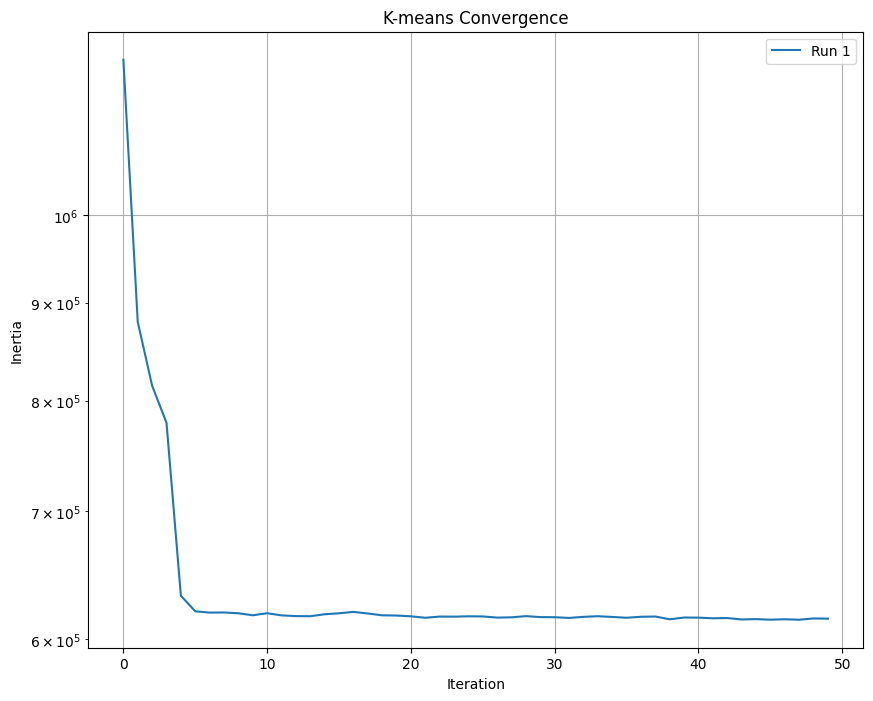

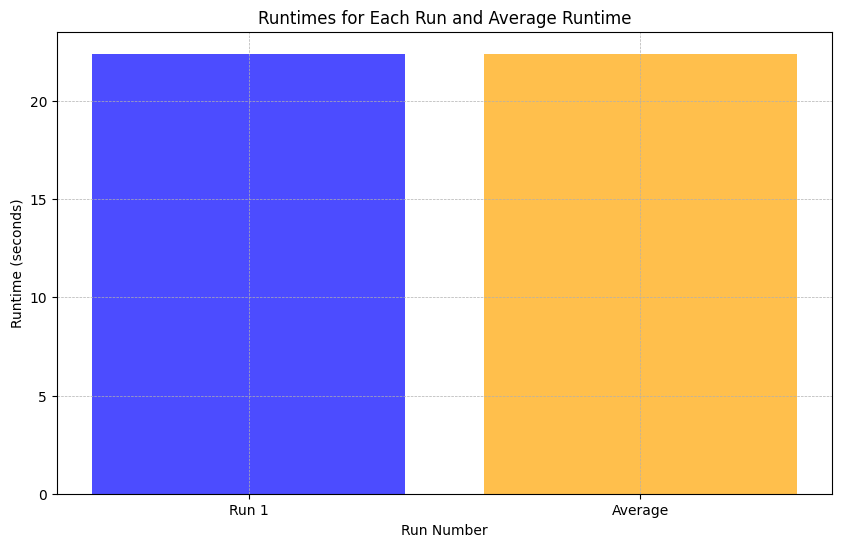

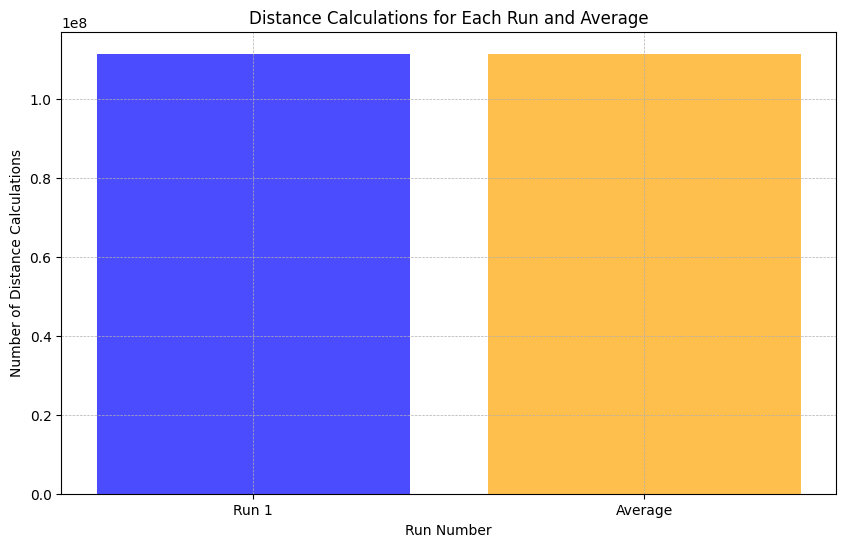

Average NMI Score: 0.2585


In [ ]:
visualize_clustering_results(results_k_means_lsh)

# Coreset K-means 

Here after the correct amount of datapoints is provided as well as the number of coresets is defined the algorithms goes to start.
First the lightweight coreset is created which creates the coresets and the weights to them. For detail for why that works please refer to the paper. 
After that a libary for k mean clustering is used which than clusters the resulting coresets. At the end the result from this clustering is used to also project the original datapoints to the clusters that were found. 
The result is than plotted with different parameters and compared.

Coreset size 100 must be at least as large as k 153, therefore k is now coreset size
Coreset size 100 must be at least as large as k 153, therefore k is now coreset size
Coreset size 100 must be at least as large as k 153, therefore k is now coreset size
Coreset size 100 must be at least as large as k 153, therefore k is now coreset size
Coreset size 100 must be at least as large as k 153, therefore k is now coreset size
Coreset size 100 must be at least as large as k 153, therefore k is now coreset size
Coreset size 100 must be at least as large as k 153, therefore k is now coreset size
Coreset size 100 must be at least as large as k 153, therefore k is now coreset size
Coreset size 100 must be at least as large as k 153, therefore k is now coreset size
Coreset size 100 must be at least as large as k 153, therefore k is now coreset size
Amount of samples in total must be at least the number of clusters/coreset size, therefore m is now at least the number of clusters or coreset size
Am

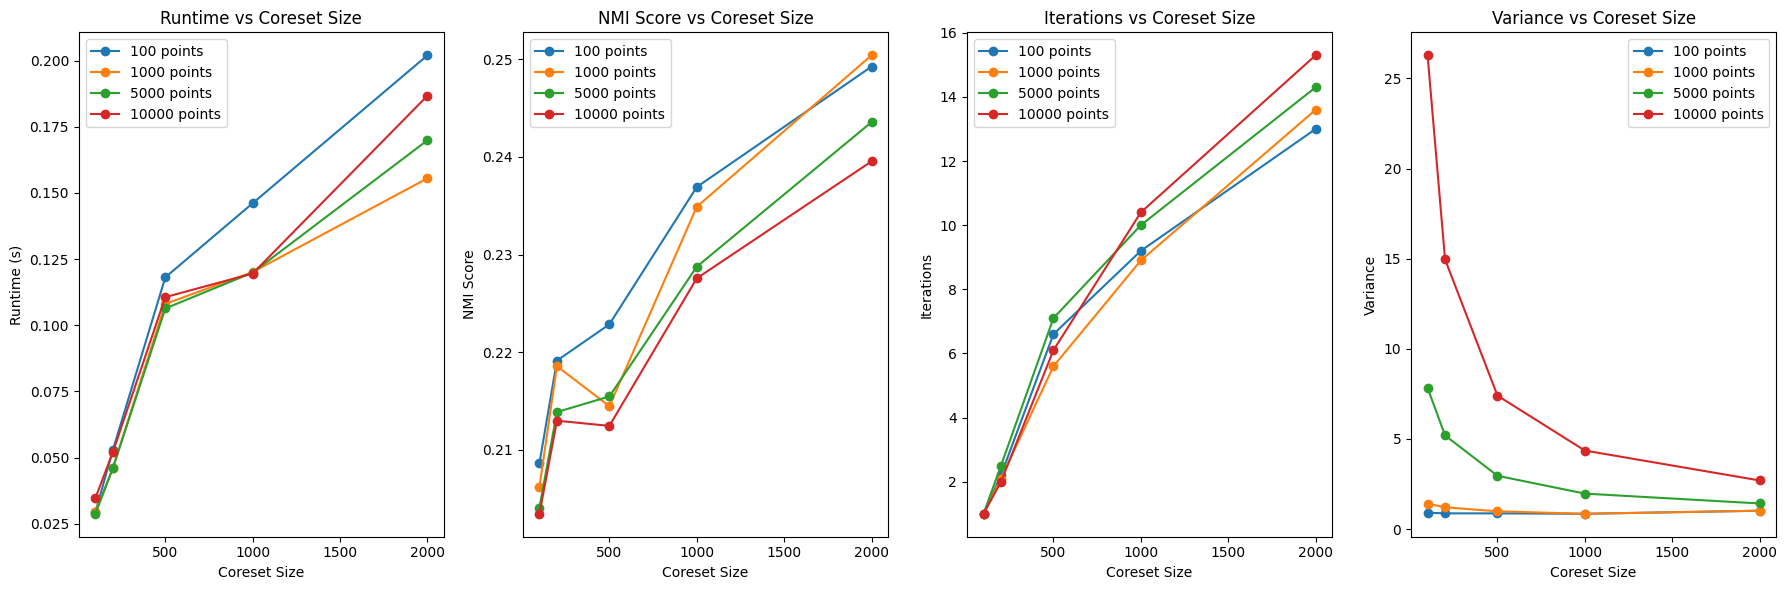

In [ ]:


# set omp threads to 1 to avoid slowdowns due to parallelization
os.environ["OMP_NUM_THREADS"] = "1"

def lightweight_coreset(X, k, m):
    n = X.shape[0]
    if n < m:
        print(f"Warning: The dataset size ({n}) is smaller than the coreset size ({m}). Consider allowing replacement or reducing the coreset size.")
        return X, np.ones(n) / n, np.arange(n)
    # Compute the mean of the data
    mu = np.mean(X, axis=0)
    # Compute distances from the mean
    dists_sq = np.sum((X - mu) ** 2, axis=1)
    total_dist_sq = np.sum(dists_sq)
    
    # Probability distribution for importance sampling
    q = 0.5 / X.shape[0] + 0.5 * dists_sq / total_dist_sq
    # Sampling according to q
    indices = np.random.choice(X.shape[0], size=m, replace=False, p=q / q.sum())
    # Compute weights inversely proportional to q
    weights = 1 / (m * q[indices])
    
    return X[indices], weights, indices

def kmeans_coreset(X, k, coreset_size, m, max_iters=100):
    start_time = time.time()
    if coreset_size < k:
        print(f"Coreset size {coreset_size} must be at least as large as k {k}, therefore k is now coreset size")
        k = coreset_size
    if m < coreset_size or m < k:
        print("Amount of samples in total must be at least the number of clusters/coreset size, therefore m is now at least the number of clusters or coreset size")
        if coreset_size < k:
            m = k
        else:
            m = coreset_size
            
    # Cut the examples
    local_X = X[:m]
    
    # Step 1: Sample the lightweight coreset
    coreset, weights, indices = lightweight_coreset(local_X, k, coreset_size)
    variance_list = [np.var(point) for point in coreset]
    # Step 2: Run K-means on the coreset using sklearn
    kmeans = KMeans(n_clusters=k, max_iter=max_iters, n_init=1, init='k-means++', random_state=0)
    kmeans.fit(coreset)
    
    centroids = kmeans.cluster_centers_
    inertia_history = [kmeans.inertia_]
    total_distance_calculations = len(coreset) * k * max_iters

    runtime = time.time() - start_time
    
    # Step 3: Assign clusters to all points
    full_labels = kmeans.predict(X)
    return centroids, full_labels, kmeans.n_iter_, inertia_history, total_distance_calculations, runtime, indices, variance_list

# Example usage with a dummy dataset
if __name__ == "__main__":

    
    point_amount = [100, 1000, 5000, 10000]
    coreset_sizes = [100, 200, 500, 1000, 2000]
    k = 153
    max_iters = 50

    # Lists to store results
    results = {m: {"nmi_scores": [], "runtimes": [], "distance_calculations": [], "var": [],"var_single": [], "inertia_histories": [], "num_iterations": [], "indices": []} for m in range(len(coreset_sizes) * len(point_amount))}
    idx = 0
    runs = 10
    for point in point_amount:
        for coreset_size in coreset_sizes:
            for _ in range(runs):  # Run each configuration 5 times
                centroids, labels, num_iterations, inertia_history, distance_calculations, runtime, indices, variance_list = kmeans_coreset(X, k, coreset_size, point, max_iters)
                nmi_score = normalized_mutual_info_score(true_labels, labels, average_method='arithmetic')
                
                # Append results to lists
                results[idx]["nmi_scores"].append(nmi_score)
                results[idx]["runtimes"].append(runtime)
                results[idx]['inertia_histories'].append(inertia_history)
                results[idx]["distance_calculations"].append(distance_calculations)
                results[idx]["num_iterations"].append(num_iterations)
                results[idx]["indices"].append(indices)
                results[idx]["var"].append(variance_list)
                if _ == 0:
                    results[idx]["var_single"].append(variance_list)
            idx += 1

    # Compute averages
    averaged_results = {}
    for m in results:
        averaged_results[m] = {
            "nmi_scores": np.mean(results[m]["nmi_scores"]),
            "runtimes": np.mean(results[m]["runtimes"]),
            "distance_calculations": np.mean(results[m]["distance_calculations"]),
            "num_iterations": np.mean(results[m]["num_iterations"]),
            "var": np.mean([np.mean(var) for var in results[m]["var"]])
        }

    # Display results
    for m in averaged_results:
        print(f"Config {m} results:")
        print(f"  NMI scores: {averaged_results[m]['nmi_scores']}")
        print(f"  Runtimes: {averaged_results[m]['runtimes']}")
        print(f"  Distance calculations: {averaged_results[m]['distance_calculations']}")
        print(f"  Number of iterations: {averaged_results[m]['num_iterations']}")
        print(f"  Average variance: {averaged_results[m]['var']}")
        # first 10 variances
        print(f"  Variance of first 10 points: {results[m]['var_single'][0][:10]}")
    print("Disclaimer, if the amount of datapoints is smaller than the amount of clusters or coreset size, the amount of datapoints is set to the amount of clusters or coreset size")

    # Plot results
    # Plot results
    plt.figure(figsize=(18, 6))
    
    for m in range(len(point_amount)):
        plt.subplot(1, 4, 1)
        plt.plot(coreset_sizes, [averaged_results[m * len(coreset_sizes) + i]['runtimes'] for i in range(len(coreset_sizes))], marker='o', label=f'{point_amount[m]} points')
        plt.title('Runtime vs Coreset Size')
        plt.xlabel('Coreset Size')
        plt.ylabel('Runtime (s)')
        
        plt.subplot(1, 4, 2)
        plt.plot(coreset_sizes, [averaged_results[m * len(coreset_sizes) + i]['nmi_scores'] for i in range(len(coreset_sizes))], marker='o', label=f'{point_amount[m]} points')
        plt.title('NMI Score vs Coreset Size')
        plt.xlabel('Coreset Size')
        plt.ylabel('NMI Score')
        
        plt.subplot(1, 4, 3)
        plt.plot(coreset_sizes, [averaged_results[m * len(coreset_sizes) + i]['num_iterations'] for i in range(len(coreset_sizes))], marker='o', label=f'{point_amount[m]} points')
        plt.title('Iterations vs Coreset Size')
        plt.xlabel('Coreset Size')
        plt.ylabel('Iterations')
        
        plt.subplot(1, 4, 4)
        plt.plot(coreset_sizes, [averaged_results[m * len(coreset_sizes) + i]['var'] for i in range(len(coreset_sizes))], marker='o', label=f'{point_amount[m]} points')
        plt.title('Variance vs Coreset Size')
        plt.xlabel('Coreset Size')
        plt.ylabel('Variance')

    # Add legends
    for i in range(1, 5):
        plt.subplot(1, 4, i)
        plt.legend()
    
    plt.tight_layout()
    plt.show()


# Assignment Instructions

## Lloyd’s algorithm for k-Means Clustering (34%)

As a baseline model implement Lloyd’s algorithm for k-means clustering and initialize it with the first k points as initial cluster centers. The default convergence criteria is to stop the algorithm if none of the cluster memberships have changed in comparison to the previous iteration.

- Include a plot illustrating convergence of k-means.
- Track the number of iterations needed for convergence and compare it to the other implementations.
- Report the achieved NMI averaged over at least 5 runs.
- Report the runtime in [sec] for your algorithm averaged over at least 5 runs. Also report the number of distance computations performed.

These 4 parts can be found with the code above

- Briefly discuss your implementation of Lloyds algorithm.

Our implementation of the Lloyd's algorithm is pretty straight forward in my opinion. 

**Initialization Step**:We first choose random starting locations for the centroids for the first step, as should be used in the assigment. K++ would yield a better result but we use dthe random starting points. 

**Assigment Step**:Than we assign the points to the closest clusters, for this the euclidian distance is used.

**Update Step**:Then calculate the center of this points and switch the centroid to that

**Iterations Step** We complete these steps until convergance is achieved. This is when the results do not get better from one step to another and stay the same. Alterantive stop is when the number of max_iterations is reached.

**Other Steps**:
Meanwhile we also track the necessary informations like distance calculations etc in order to visualize them later.
Regarding the assigment of the cluster we do this batch wise in 100 steps in order to increase efficency. For the distance we use the euclidian distance








## k-Means with Locality Sensitive Hashing (LSH) (33%)

Implement Lloyd’s algorithm using LSH to speed up the distance calculations. See the uploaded presentation on Moodle on how LSH should be used.

Try out different settings in which you combine different hash functions with AND and OR as it was discussed in the lecture. For example, you can have one setting where you combine two hash functions with AND and in the second setting you combine two functions with OR, but you could try out several combinations, with different hash functions. Also try varying the number of buckets of your hashing function. Measure the runtime timeLSH of your LSH implementation.

- Report how you selected the parameters of LSH and how you combined your functions.
- Report the accuracy using NMI and the runtime in seconds averaged over at least 5 runs. Also report the number of distance computations performed. If your implementation doesn’t show a speed-up, discuss why this might be and also discuss whether this situation would change when working larger datasets.
- Track the number of iterations needed for convergence (if it converges at all) and compare it to the other implementations.
- Briefly discuss your implementation of k-means with LSH.

# k-means with coresets (33%)

Coresets are a compact representation of data sets, such that models trained on a coreset are competitive with models trained on the full dataset. In this task you will implement coresets for k-means clustering as in [1, Algorithm 1]. For the number of samples m, use 100, 1000, and 10000.

- Report the runtime and NMI you achieve when using coresets of different size (as described above) averaged over at least 5 runs. To do so, cluster the coresets using sklearn’s k-means algorithm (you can supply sample weights to all needed functions).
- Track the number of iterations needed for convergence and compare it to the other implementations.
- Analyze the variance of the accuracy obtained when using coresets for clustering by computing 10 coresets for each choice of m.

# Implementation Comments

I implemented the coreset method as described in the paper to create coresets, which are then clustered using K-Means. All the points are projected onto these clusters to obtain the final result.

## Parameters
I was uncertain whether `m` refers to the number of data points used for creating the coreset or the number of coresets. Consequently, I made both of these variables configurable. This is quite interesting, as shown in the graphs.

## Rules and Assumptions
1. If the number of data points used is smaller than `coreset_size` or `clusters`, it gets set to the maximum of these two values.
2. The number of clusters should not exceed the number of coresets.

These rules are practical and prevent useless configurations.

## Performance Analysis
The detailed runtimes and NMI (Normalized Mutual Information) can be found in the graph above, along with the number of iterations needed.

Compared to other implementations, the coreset method requires fewer iterations to converge. This is logical since clustering has a smaller problem space due to fewer points being used, which generally results in better performance. A lower coreset size significantly reduces the required number of iterations.

## Variance Analysis
I also analyzed the variance, focusing first on the required 10 coresets. Detailed variance information for each coreset can be found above the plot in the coreset code. The variance was calculated for all points in one coreset.

Let's examine three configurations:

### Configuration 1: (m=1000, coreset_size=200)
Variance of first 10 points:
```
[0.672, 1.326, 24.918, 0.467, 2.127, 1.093, 0.544, 0.554, 0.863, 0.553]
```

### Configuration 2: (m=10,000, coreset_size=2000)
Variance of first 10 points:
```
[3.346, 0.534, 2.058, 0.924, 0.603, 1.609, 0.741, 0.641, 0.836, 0.660]
```

### Configuration 3: (m=10,000, coreset_size=200)
Variance of first 10 points:
```
[50.082, 0.607, 0.572, 2.006, 1805.890, 0.489, 0.514, 1.420, 0.625, 0.290]
```

## Observations
- **Configuration 1**: When few points are used, the variance is generally low, except for one point with a high variance of 25, likely due to an outlier.
- **Configuration 2**: With many points and many coresets, the variance is low on average, with fewer outliers.
- **Configuration 3**: With many points and few coresets, most coresets still have a low variance. However, one coreset shows a very high variance (1805), probably due to multiple outliers concentrated in that coreset.

## General Trend
The variance tends to be higher when more points (`m`) are used for clustering and tends to decrease with a larger coreset size, which aligns with expectations.




## Report

Write a report about your work on this assignment, your findings and results. Make sure to report all the information indicated above. Additionally report the following:

- Show the performance in terms of NMI and runtime for the different approaches in one plot or table.

K-means Iteration:   0%|          | 0/10 [00:00<?, ?it/s]

K-means Iteration: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


  Algorithm       NMI  Runtime (s)
0     Lloyd  0.274028    10.503282
1       LSH  0.259944     4.520329
2   Coreset  0.261132     0.335901


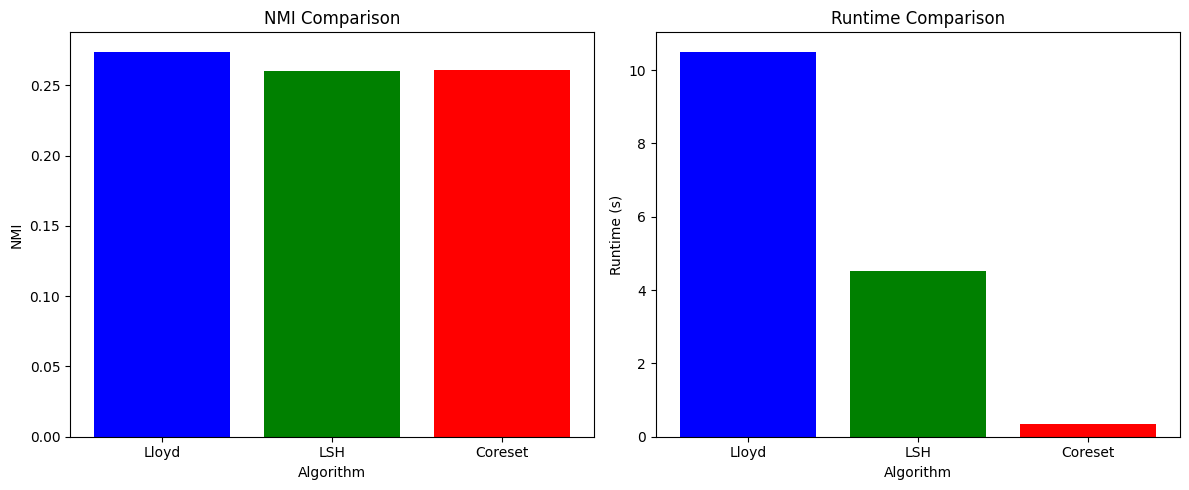

In [ ]:



# Placeholder function for Lloyd's algorithm (KMeans)
def run_lloyd_algorithm(data, labels_true):
    start_time = time.time()
    centroids, labels_pred, iteration, inertia_history, total_distance_calculations, runtime = kmeans(X_scaled, 153, 10)
    nmi = normalized_mutual_info_score(labels_true, labels_pred)
    runtime = time.time() - start_time
    return nmi, runtime

# Placeholder function for LSH algorithm (simulated)
def run_lsh_algorithm(data, labels_true):
    start_time = time.time()
    # Simulate LSH algorithm
    centroids, labels_pred, iteration, inertia_history, total_distance_calculations, runtime = results_k_means_lsh = kmeans_lsh(X_scaled, 153, 10)
    nmi = normalized_mutual_info_score(labels_true, labels_pred)
    runtime = time.time() - start_time
    return nmi, runtime

# Placeholder function for Coreset algorithm (simulated)
def run_coreset_algorithm(data, labels_true):
    start_time = time.time()
    # Simulate Coreset algorithm
    centroids, labels_pred, num_iterations, inertia_history, distance_calculations, runtime, indices, variance_list = kmeans_coreset(X, 153, 10000, 50000, 10)
    nmi = normalized_mutual_info_score(labels_true, labels_pred)
    runtime = time.time() - start_time
    return nmi, runtime



# Collect results from each algorithm
results = []
algorithms = ['Lloyd', 'LSH', 'Coreset']
data = X_scaled
labels_true = true_labels
for algo in algorithms:
    if algo == 'Lloyd':
        nmi, runtime = run_lloyd_algorithm(data, labels_true)
    elif algo == 'LSH':
        nmi, runtime = run_lsh_algorithm(data, labels_true)
    elif algo == 'Coreset':
        nmi, runtime = run_coreset_algorithm(data, labels_true)
    
    results.append({
        'Algorithm': algo,
        'NMI': nmi,
        'Runtime (s)': runtime
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)
# Plot the NMI for each algorithm
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(results_df['Algorithm'], results_df['NMI'], color=['blue', 'green', 'red'])
plt.xlabel('Algorithm')
plt.ylabel('NMI')
plt.title('NMI Comparison')

# Plot the runtime for each algorithm
plt.subplot(1, 2, 2)
plt.bar(results_df['Algorithm'], results_df['Runtime (s)'], color=['blue', 'green', 'red'])
plt.xlabel('Algorithm')
plt.ylabel('Runtime (s)')
plt.title('Runtime Comparison')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

K-means Iteration: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


  Algorithm       NMI  Runtime (s)
0     Lloyd  0.271809    11.591253
1       LSH  0.254790     4.923235
2   Coreset  0.263960     0.496416


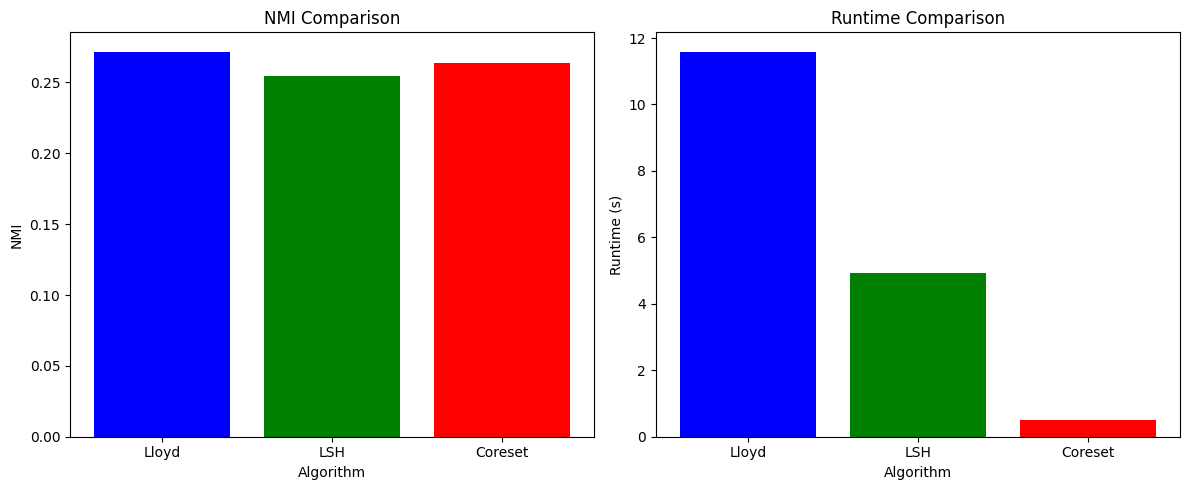

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score

# Placeholder function for Lloyd's algorithm (KMeans)
def run_lloyd_algorithm(data, labels_true):
    start_time = time.time()
    centroids, labels_pred, iteration, inertia_history, total_distance_calculations, runtime = kmeans(data, 153, 10)
    nmi = normalized_mutual_info_score(labels_true, labels_pred)
    runtime = time.time() - start_time
    return nmi, runtime

# Placeholder function for LSH algorithm (simulated)
def run_lsh_algorithm(data, labels_true):
    start_time = time.time()
    centroids, labels_pred, iteration, inertia_history, total_distance_calculations, runtime = kmeans_lsh(data, 153, 10)
    nmi = normalized_mutual_info_score(labels_true, labels_pred)
    runtime = time.time() - start_time
    return nmi, runtime

# Placeholder function for Coreset algorithm (simulated)
def run_coreset_algorithm(data, labels_true):
    start_time = time.time()
    centroids, labels_pred, num_iterations, inertia_history, distance_calculations, runtime, indices, variance_list = kmeans_coreset(data, 153, 10000, 50000, 10)
    nmi = normalized_mutual_info_score(labels_true, labels_pred)
    runtime = time.time() - start_time
    return nmi, runtime

# Function to run an algorithm multiple times and get average results
def run_multiple_times(run_algorithm, data, labels_true, num_runs=10):
    nmi_scores = []
    runtimes = []
    for _ in range(num_runs):
        nmi, runtime = run_algorithm(data, labels_true)
        nmi_scores.append(nmi)
        runtimes.append(runtime)
    avg_nmi = np.mean(nmi_scores)
    avg_runtime = np.mean(runtimes)
    return avg_nmi, avg_runtime

# Collect results from each algorithm
results = []
algorithms = ['Lloyd', 'LSH', 'Coreset']
data = X_scaled
labels_true = true_labels

for algo in algorithms:
    if algo == 'Lloyd':
        avg_nmi, avg_runtime = run_multiple_times(run_lloyd_algorithm, data, labels_true)
    elif algo == 'LSH':
        avg_nmi, avg_runtime = run_multiple_times(run_lsh_algorithm, data, labels_true)
    elif algo == 'Coreset':
        avg_nmi, avg_runtime = run_multiple_times(run_coreset_algorithm, data, labels_true)
    
    results.append({
        'Algorithm': algo,
        'NMI': avg_nmi,
        'Runtime (s)': avg_runtime
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

# Plot the NMI for each algorithm
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(results_df['Algorithm'], results_df['NMI'], color=['blue', 'green', 'red'])
plt.xlabel('Algorithm')
plt.ylabel('NMI')
plt.title('NMI Comparison')

# Plot the runtime for each algorithm
plt.subplot(1, 2, 2)
plt.bar(results_df['Algorithm'], results_df['Runtime (s)'], color=['blue', 'green', 'red'])
plt.xlabel('Algorithm')
plt.ylabel('Runtime (s)')
plt.title('Runtime Comparison')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
